In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from scipy.spatial.distance import pdist, squareform
import scanpy as sc
from sklearn.cluster import KMeans

exec(compile(open(r"../nsimplices.py", encoding="utf8").read(), "nsimplices.py", 'exec'))

In [2]:
dataset_id = 'Baron'
df_gene = pd.read_csv(f"~/nSimplices/data/sce_full_{dataset_id}_scScope_log.csv", index_col=0, header=0)
df_gene = df_gene.iloc[823:] # only get mouse 2 samples 

print(df_gene.shape)
df_gene

(1063, 13357)


,X0610007P14Rik,X0610009B22Rik,X0610009E02Rik,X0610009L18Rik,X0610009O20Rik,X0610010F05Rik,X0610010K14Rik,X0610011F06Rik,X0610012G03Rik,X0610030E20Rik,...,Zw10,Zwilch,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
mouse2_lib1.final_cell_0002,1.622580,0.856702,0.517418,0.0,0.0,0.0,0.0,0.000000,0.000000,0.517418,...,0.517418,0.0,0.856702,0.000000,0.000000,0.000000,0.000000,0.856702,0.000000,0.000000
mouse2_lib1.final_cell_0003,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.907311,0.553210,0.000000,...,0.000000,0.0,1.375057,0.000000,0.000000,1.375057,0.000000,0.000000,0.907311,0.000000
mouse2_lib1.final_cell_0004,0.850549,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.850549,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.470711,0.000000,0.513103,0.513103
mouse2_lib1.final_cell_0005,0.000000,0.619066,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.619066,0.619066,0.619066,0.000000,0.000000,0.000000,0.000000
mouse2_lib1.final_cell_0006,0.000000,0.618157,0.000000,0.0,0.0,0.0,0.0,0.618157,0.618157,0.000000,...,0.000000,0.0,0.618157,0.000000,0.000000,0.618157,0.000000,0.618157,0.000000,0.997321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mouse2_lib3.final_cell_0391,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mouse2_lib3.final_cell_0392,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,2.462117,0.000000,0.000000,0.000000,0.000000,0.000000,2.462117,0.000000
mouse2_lib3.final_cell_0393,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,1.923451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mouse2_lib3.final_cell_0394,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.036882,0.000000,0.000000,0.000000


In [3]:
# filter out cells with > 0.95 dropout rates
delete_indices = []
dropout_thres = 0.95
for index, row in df_gene.iterrows():
    if list(row).count(0) > df_gene.shape[1]*dropout_thres:
        delete_indices.append(index)

df_gene = df_gene.drop(delete_indices)
print("data matrix shape is:", df_gene.shape)

data matrix shape is: (1063, 13357)


In [4]:
# select highly variable genes 
adata = sc.AnnData(df_gene.values)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat")
highly_variable_gene_object = adata.var[adata.var['highly_variable']].sort_values('dispersions_norm', ascending=False)
highly_variable_gene_indices = highly_variable_gene_object.index.tolist()
highly_variable_gene_indices = [int(x) for x in highly_variable_gene_indices]
gene_names = np.array(df_gene.columns)
highly_variable_genes = gene_names[highly_variable_gene_indices]
print("number of highly variable genes is:", len(highly_variable_genes))


number of highly variable genes is: 2601


In [5]:
# select highly expressed genes

# preprocess the dataset 
df_array = np.array(df_gene[highly_variable_genes])
gene_meds = np.median(df_array, axis=0)
genes = df_gene.columns.values
print("number of genes", gene_meds.shape)

zipped = zip(gene_meds, genes)
    
# Sort the zipped array based on the values in the first array
sorted_zipped = sorted(zipped, key=lambda x: x[0], reverse=True)

# Unzip the sorted array
sorted_gene_meds, sorted_genes = zip(*sorted_zipped)

med_counts_dict = {}
for gene, med in zip(sorted_genes, sorted_gene_meds):
    med_counts_dict[gene] = med

# only consider the top n expressed genes
num_top_genes = 2601
top_genes = sorted_genes[:num_top_genes]
df_gene_top = df_gene.loc[:, top_genes] 

print("data matrix shape is:", df_gene_top.shape)


number of genes (2601,)
data matrix shape is: (1063, 2601)


In [6]:
# # filter out cells with more than 100 zero counts
# delete_indices = []
# for index, row in df_gene_top.iterrows():
#     if list(row).count(0) > df_gene_top.shape[1]*0.97:
#         delete_indices.append(index)

# df_gene_top = df_gene_top.drop(delete_indices)
# print("data matrix shape is", df_gene_top.shape)


In [30]:

### Run nSimplices method
feature_num = df_gene_top.shape[1]
dim_start = 2
dim_end = 10
out_dis = pdist(df_gene_top)
out_dis_sq = squareform(out_dis)
num_point = df_gene_top.shape[0]

outlier_indices, subspace_dim, corr_dis_sq, corr_coord = nsimplices(out_dis_sq, feature_num, dim_start, dim_end, euc_coord=np.array(df_gene_top.copy()), std_multi=2)

idx is: 186 height is: 16.244348419723114 thres is: 15.553975227220944
idx is: 210 height is: 15.699844832572765 thres is: 15.553975227220944
idx is: 219 height is: 15.813912587897267 thres is: 15.553975227220944
idx is: 232 height is: 15.911850670979629 thres is: 15.553975227220944
idx is: 253 height is: 16.162523987919098 thres is: 15.553975227220944
idx is: 259 height is: 15.554709330236637 thres is: 15.553975227220944
idx is: 260 height is: 16.694355255080964 thres is: 15.553975227220944
idx is: 263 height is: 16.624122406581435 thres is: 15.553975227220944
idx is: 266 height is: 16.512318194888522 thres is: 15.553975227220944
idx is: 267 height is: 15.795603093226159 thres is: 15.553975227220944
idx is: 278 height is: 16.491590766617445 thres is: 15.553975227220944
idx is: 282 height is: 15.774415063920092 thres is: 15.553975227220944
idx is: 286 height is: 15.738149777188028 thres is: 15.553975227220944
idx is: 289 height is: 16.05079526262937 thres is: 15.553975227220944
idx is:

In [8]:
print("number of outliers is:", len(outlier_indices), "outlier percent is:", len(outlier_indices)/num_point, "subspace dimension is:", subspace_dim)

number of outliers is: 77 outlier percent is: 0.07243650047036689 subspace dimension is: 3


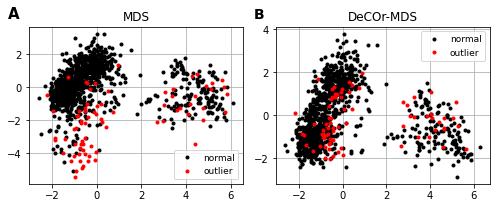

In [9]:
normal_indices=[i for i in range(num_point) if i not in outlier_indices] # list of normal points 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))



# plot original graphs with outliers added 
va, ve, Xe = cMDS(out_dis_sq)
ax1.plot(Xe[normal_indices,0],Xe[normal_indices,1],'.', color='black', label="normal")
ax1.plot(Xe[outlier_indices,0],Xe[outlier_indices,1],'.',color='red', label="outlier")
ax1.legend(fontsize=9)
ax1.grid()
ax1.set_title("MDS")
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
        size=15, weight='bold')

# plot correct outliers 
va, ve, Xe = cMDS(corr_dis_sq)   
ax2.plot(Xe[normal_indices,0],-Xe[normal_indices,1],'.', color='black', label="normal")
ax2.plot(Xe[outlier_indices,0],-Xe[outlier_indices,1],'.',color='red', label="outlier")
ax2.legend(fontsize=9)
ax2.set_title("DeCOr-MDS")
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
        size=14, weight='bold')
ax2.grid()
plt.tight_layout()
fig_path =  f"../outputs/{dataset_id}_var_MDS_xy.pdf"
# plt.savefig(fig_path)
plt.show()
plt.close()

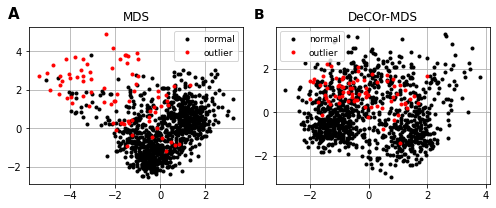

In [10]:


normal_indices=[i for i in range(num_point) if i not in outlier_indices] # list of normal points 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))



# plot original graphs with outliers added 
va, ve, Xe = cMDS(out_dis_sq)
ax1.plot(Xe[normal_indices,1],Xe[normal_indices,2],'.', color='black', label="normal")
ax1.plot(Xe[outlier_indices,1],Xe[outlier_indices,2],'.',color='red', label="outlier")
ax1.legend(fontsize=9)
ax1.grid()
ax1.set_title("MDS")
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
        size=15, weight='bold')

# plot correct outliers 
va, ve, Xe = cMDS(corr_dis_sq)   
ax2.plot(-Xe[normal_indices,1],Xe[normal_indices,2],'.', color='black', label="normal")
ax2.plot(-Xe[outlier_indices,1],Xe[outlier_indices,2],'.',color='red', label="outlier")
ax2.legend(fontsize=9)
ax2.set_title("DeCOr-MDS")
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
        size=14, weight='bold')
ax2.grid()
plt.tight_layout()
fig_path =  f"../outputs/{dataset_id}_var_MDS_yz.pdf"
# plt.savefig(fig_path)
plt.show()
plt.close()

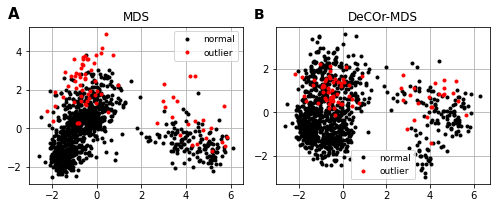

In [11]:
normal_indices=[i for i in range(num_point) if i not in outlier_indices] # list of normal points 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))



# plot original graphs with outliers added 
va, ve, Xe = cMDS(out_dis_sq)
ax1.plot(Xe[normal_indices,0],Xe[normal_indices,2],'.', color='black', label="normal")
ax1.plot(Xe[outlier_indices,0],Xe[outlier_indices,2],'.',color='red', label="outlier")
ax1.legend(fontsize=9)
ax1.grid()
ax1.set_title("MDS")
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
        size=15, weight='bold')

# plot correct outliers 
va, ve, Xe = cMDS(corr_dis_sq)   
ax2.plot(Xe[normal_indices,0],Xe[normal_indices,2],'.', color='black', label="normal")
ax2.plot(Xe[outlier_indices,0],Xe[outlier_indices,2],'.',color='red', label="outlier")
ax2.legend(fontsize=9)
ax2.set_title("DeCOr-MDS")
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
        size=14, weight='bold')
ax2.grid()
plt.tight_layout()
fig_path =  f"../outputs/{dataset_id}_var_MDS_xz.pdf"
# plt.savefig(fig_path)
plt.show()
plt.close()

In [32]:
# 3D plot

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio


outlier_inds = np.zeros(df_gene_top.shape[0])
outlier_inds[outlier_indices] = 1

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'scene'}, {'type': 'scene'}]],
                    subplot_titles=('MDS',  'DeCOr-MDS'))

va, ve, Xe_MDS = cMDS(out_dis_sq)

# fig.add_trace(
#     go.Scatter3d(x=Xe[normal_indices, 0], y=[normal_indices, 1], z=Xe[normal_indices, 2], mode='markers', \
#                  marker=dict(size=3, color='yellow')),
#         row=1, col=1)

camera = dict(
    up=dict(x=0, y=1, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
    # eye = dict(x=0., y=2.5, z=0)
)


fig.add_trace(
    go.Scatter3d(x=Xe_MDS[normal_indices, 0], y=Xe_MDS[normal_indices, 1], z=Xe_MDS[normal_indices, 2], mode='markers', name = "normal", marker=dict(size=3, color='blue')),
    row=1, col=1
)
# fig.update_layout(scene_camera=camera)


fig.add_trace(
    go.Scatter3d(x=Xe_MDS[outlier_indices, 0], y=Xe_MDS[outlier_indices, 1], z=Xe_MDS[outlier_indices, 2], mode='markers', name = "outlier", marker=dict(size=3, color='red')),
    row=1, col=1
)
# fig.update_layout(scene_camera=camera)


va, ve, Xe_De = cMDS(corr_dis_sq)   

fig.add_trace(
    go.Scatter3d(x=Xe_De[normal_indices, 0], y=-Xe_De[normal_indices, 1], z=Xe_De[normal_indices, 2], mode='markers', name = "normal", marker=dict(size=3, color='blue')),
    row=1, col=2
)
# fig.update_layout(scene_camera=camera)


fig.add_trace(
    go.Scatter3d(x=Xe_De[outlier_indices, 0], y=-Xe_De[outlier_indices, 1], z=Xe_De[outlier_indices, 2], mode='markers', name = "outlier", marker=dict(size=3, color='red')),
    row=1, col=2
)
# fig.update_layout(scene_camera=camera)


# fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()
fig_path = f"../outputs/{dataset_id}_var_MDS_3D.html"
# fig.write_html(fig_path)

fig_path = f"../outputs/{dataset_id}_var_MDS_3D.pdf"
pio.write_image(fig, fig_path, width=1200, height=500)


In [13]:

""" 
Compute the average distance between the outliers and the barycenter of regular points
"""

def centeroid(coords_list):
    """ 
    Computes the barycenter of a list of coordinates in coords_list
    """

    length = coords_list.shape[0]
    centroid = []
    for i in range(coords_list.shape[1]):
        centroid.append(np.sum(coords_list[:, i])/length)
    return np.array(centroid)

normal_centroid_MDS = centeroid(Xe_MDS[normal_indices, :]) # should only focus on the first inferred dimension coordinates
normal_centroid_MDS = normal_centroid_MDS[:subspace_dim]
outlier_Xe_MDS = Xe_MDS[outlier_indices, :subspace_dim]

    
# compute distance
total_distance = 0
for outlier_coord in outlier_Xe_MDS:
    total_distance += np.linalg.norm(outlier_coord-normal_centroid_MDS)
print("MDS average distance is:", total_distance/len(outlier_indices))

normal_centroid_De = centeroid(Xe_De[normal_indices, :]) # should only focus on the first inferred dimension coordinates
normal_centroid_De = normal_centroid_De[:subspace_dim]
outlier_Xe_De = Xe_De[outlier_indices, :subspace_dim]

# compute distance
total_distance = 0
for outlier_coord in outlier_Xe_De:
    total_distance += np.linalg.norm(outlier_coord-normal_centroid_De)
print("DeCOr-MDS average distance is:", total_distance/len(outlier_indices))


MDS average distance is: 4.223067434690272
DeCOr-MDS average distance is: 2.5132098259499873


In [29]:
from sklearn.metrics import pairwise_distances

# Compute the distance between centroid of two clusters in subspace dimension
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
embedding = Xe_MDS[:, :subspace_dim]
kmeans.fit(embedding)
cluster_centroids = kmeans.cluster_centers_
distance = np.linalg.norm(cluster_centroids[0]-cluster_centroids[1])
print("distance between two cluster centroids is:", distance)

# Compute average pairwise distance between two clusters 
distances = kmeans.transform(embedding)
cluster_labels = kmeans.predict(embedding)
cluster_indices = [np.where(cluster_labels == i)[0] for i in range(n_clusters)]

pairwise_dist = pairwise_distances(embedding[cluster_indices[0]], embedding[cluster_indices[1]])
# print(pairwise_dist)
min_pairwise_dist = min(pairwise_dist.reshape(pairwise_dist.shape[0]*pairwise_dist.shape[1]))

print("minimum pairwise distance between clusters:", min_pairwise_dist)

[[-0.79554796  0.08018221  0.1080698 ]
 [ 4.29883444 -0.43327376 -0.58396753]]
distance between two cluster centroids is: 5.16674798414659
minimum pairwise distance between clusters: 1.2795585074230085


/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [15]:
# examine the gene expression count profile

def count_outlier_percent(all_counts, outlier_counts):
    def find_outlier_bound(all_counts):
        # Calculate the first and third quartiles (Q1 and Q3)
        q1 = np.percentile(all_counts, 25)
        q3 = np.percentile(all_counts, 75)

        # Calculate the interquartile range (IQR)
        iqr = q3 - q1

        # Define the lower and upper bounds for outliers
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        return lower_bound, upper_bound
    
    lower_bound, upper_bound = find_outlier_bound(all_counts)

    return sum((count > upper_bound or count < lower_bound) for count in outlier_counts)/len(outlier_counts)

In [16]:
# compute the drop out rate for all cells, and compute the drop out rate for outliers

def compute_drop_out(df, outlier_indices):
    """ 
    @param Dataframe df: The dataframe containing all cells 
    @param list[int] outlier_indices: The outlier indices 

    Returns the dropout rates and the outlier drop out rates 
    """
    drop_outs = []
    outlier_drop_outs = []

    num_index = 0
    for _, row in df.iterrows():
        zero_rate = sum(i == 0 for i in list(row))/float(df.shape[1])
        drop_outs.append(zero_rate)
        if num_index in outlier_indices:
            outlier_drop_outs.append(zero_rate)
        num_index += 1
    
    return drop_outs, outlier_drop_outs

(1063, 500)


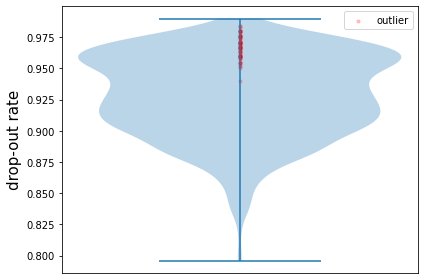

In [38]:
# compute the drop out rate for the top highly expressed genes
num_subset = 500
subset_top_genes = top_genes[:num_subset]
df_gene_top_subset = df_gene_top.loc[:, subset_top_genes] 
print(df_gene_top_subset.shape)

drop_outs, outlier_drop_outs = compute_drop_out(df_gene_top_subset, outlier_indices)

fig = plt.figure()
ax = plt.gca()
label_size = 15
ax.violinplot(drop_outs)
ax.set_xticklabels([])
# ax.violinplot(outlier_drop_outs)
plt.scatter(x=[1]*len(outlier_drop_outs), y=outlier_drop_outs, s=10, alpha=0.2, c='red', label='outlier')
# print(min(outlier_drop_outs))
# plt.scatter(x=[1], y=[min(outlier_drop_outs)], c='red')
plt.ylabel("drop-out rate", fontsize=label_size)
plt.yticks(fontsize=10)
plt.legend()
# plt.title('Dropout rates for the top 50 highly expressed genes')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tight_layout()
fig_path = f"../outputs/{dataset_id}_var_dropout_violin.pdf"
plt.savefig(fig_path)
plt.show()


In [40]:
# Compute the percent of outlier dropout rates that are greater than dropout threshold
count = len([x for x in outlier_drop_outs if x > dropout_thres])
print("percent of outliers having dropout rates > 0.95 over the 500 highly expressed genes:", count/len(outlier_drop_outs))

percent of outliers having dropout rates > 0.95 over the 500 highly expressed genes: 0.974025974025974


In [19]:
# perform pairwise T-test for all pairs between outliers and normal points
normal_indices=[i for i in range(num_point) if i not in outlier_indices]
outlier_df = df_gene_top.iloc[outlier_indices]
normal_df = df_gene_top.iloc[normal_indices]

outlier_total_counts = np.array(outlier_df).sum(axis=1)
normal_total_counts = np.array(normal_df).sum(axis=1)

pairs = []
for outlier_total_count in outlier_total_counts:
    for normal_total_count in normal_total_counts:
        pairs.append(normal_total_count-outlier_total_count)

num_pair = len(outlier_total_counts)*len(normal_total_counts)
degree = num_pair-1
 
est_mean = sum(pairs)/num_pair

# calculate standard deviation

est_sd = np.sqrt(sum([(pair-est_mean)**2 for pair in pairs])/degree)

# calculate the standard error of the mean
est_se = est_sd/np.sqrt(num_pair)

# calculate t-value
t_value = est_mean/est_se

print("degree of freedom:", degree, "t_value is:", t_value)

degree of freedom: 75921 t_value is: 312.5183407701729


In [20]:
# the t-value 105.81678660378093 is greater than the critical t value of degree 9569 (1.960-1.960), the null hypothesis is rejected.
# Significant level = 0.05
# The total counts from outlier group is significantly different from the total counts from the normal group.